In [3]:
import pandas as pd
import numpy as np
import json
import glob
import pandas as pd
import csv

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy
import spacy
from nltk.corpus import stopwords


In [4]:
# Bag of words for each category to classify text

topics = {"fee": ["fee", "money", "price", "cost", "expensive", "cost", "charge"],
        "transaction": ["deposit", "withdrawal", "bank", "delay", "debit", "credit", "card"],
        "trust": ["company", "scam"], #! Add more words to trust
        "service": ["service", "customer", "contact", "support", "email"],
        "app": ["interface", "easy", "friendly", "clean", "user"]}

        # Could use TFIDF to get keywords

In [21]:
# Pre-processing the document
all_files = ["coinbase.csv", "binance.csv", "ftx.csv", "kraken.csv"]

# Combine all the csv files into one
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

# Get only rows with >50 chars or about 10 words
def get_rows(row):
    row["sufficient_len"] = True if type(row["content"]) == str and len(row["content"]) > 50 else False;
    return row;
    
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.loc[:, ["reviewId", "content", "score", "at"]]
frame = frame.apply(get_rows, axis=1)
frame = frame.loc[frame["sufficient_len"] == True]
frame


,reviewId,content,score,at,sufficient_len
2,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,True
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,True
4,c592afe5-b785-49f7-a760-c663f516d303,Was liking it all the way up til the part wher...,1,2022-07-01 08:56:03,True
5,4d1e73a6-5209-4e16-bfd2-008da201c5c5,Not your keys not your crypto. They're also se...,1,2022-07-01 08:48:22,True
8,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,True
...,...,...,...,...,...
19877,ffac6965-3de9-4d5b-9c36-5426d925dd12,Slick design and easy to use. Still have to us...,5,2020-11-17 19:11:44,True
19878,5d11a98a-6989-4244-85f2-be72ac295040,"Clean, simple to use app, PLEASE PUT A FIELD W...",5,2020-11-17 18:57:57,True
19879,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,"Unbelievable. This is by far the most easy, us...",5,2020-11-17 18:31:37,True
19880,2ba1ad26-be94-462a-a5df-8d62224abe73,No crypto deposit/withdraw options. Useless. H...,1,2020-11-16 13:30:54,True


In [22]:
# Process documents and insert to df

spacy.load
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
allowed_postags=["NOUN", "ADJ"]
stop_words=stopwords.words("english")
def insert_processed_doc(row):

    # Lemmatization
    text = row["content"]
    doc = nlp(text) # Create document from the raw text/string
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags and token.pos_ not in stop_words:
            new_text.append(token.lemma_) # Appends only lemma to new_text
    lemma = " ".join(new_text)
 
    # Remove marks and make everything lowercase
    final_doc = gensim.utils.simple_preprocess(lemma, deacc=True);

    row["content_proc"] = final_doc
    return row

frame = frame.apply(insert_processed_doc, axis=1)

frame


,reviewId,content,score,at,sufficient_len,content_proc
2,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,True,"[need, old, format, much, time, gainer, loser]"
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,True,"[problem, money, crypto, suspicious, customer,..."
4,c592afe5-b785-49f7-a760-c663f516d303,Was liking it all the way up til the part wher...,1,2022-07-01 08:56:03,True,"[way, part, info, ice, bueno]"
5,4d1e73a6-5209-4e16-bfd2-008da201c5c5,Not your keys not your crypto. They're also se...,1,2022-07-01 08:48:22,True,"[key, crypto, location, datum, enjoy]"
8,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,True,"[guy, payment, mood, debit, card]"
...,...,...,...,...,...,...
19877,ffac6965-3de9-4d5b-9c36-5426d925dd12,Slick design and easy to use. Still have to us...,5,2020-11-17 19:11:44,True,"[slick, design, easy, advanced, feature, quick..."
19878,5d11a98a-6989-4244-85f2-be72ac295040,"Clean, simple to use app, PLEASE PUT A FIELD W...",5,2020-11-17 18:57:57,True,"[clean, simple, app, field, price, market, pri..."
19879,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,"Unbelievable. This is by far the most easy, us...",5,2020-11-17 18:31:37,True,"[unbelievable, easy, user, friendly, interface..."
19880,2ba1ad26-be94-462a-a5df-8d62224abe73,No crypto deposit/withdraw options. Useless. H...,1,2020-11-16 13:30:54,True,"[crypto, deposit, option, useless, browser, po..."


In [7]:
# Returns the topic which the processed_doc contains the most words from
def get_topic(topics, processed_doc):
    topic_scores = dict.fromkeys(topics, 0)
    for word in processed_doc:
        for topic in topics.keys():
            if word in topics[topic]: topic_scores[topic] += 1
    topic_max = max(topic_scores, key=topic_scores.get)  
    if topic_scores[topic_max] == 0: topic_max = "N"     
    return (topic_max, topic_scores[topic_max] if topic_max != "N" else 0)

In [8]:
def insert_topic(row):
    topic_max, topic_score = get_topic(topics, row["content_proc"])
    row["topic"] = topic_max
    row["topic_score"] = topic_score
    return row

frame = frame.apply(insert_topic, axis=1)

In [9]:
frame.loc[frame["topic"] != "N"]

,reviewId,content,score,at,sufficient_len,content_proc,topic,topic_score
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,True,"[problem, money, crypto, suspicious, customer,...",fee,2
8,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,True,"[guy, payment, mood, debit, card]",transaction,2
10,273ef3ba-4b5a-4ee8-81f3-08fc7adeda89,"Terrible, unethical, useless support team. Jus...",1,2022-07-01 06:37:10,True,"[terrible, unethical, useless, support, team, ...",trust,1
12,9e8114f4-7b1c-480e-b06a-62c613ca6be6,Good bye coinbase - I will not miss your high ...,1,2022-07-01 06:08:08,True,"[coinbase, high, fee, par, chart, decision, ot...",fee,1
14,8bd52842-28da-43dd-8386-382ae169521e,They do not support the privacy of their users...,1,2022-07-01 05:32:47,True,"[privacy, user, developer, application, datum,...",app,1
...,...,...,...,...,...,...,...,...
19877,ffac6965-3de9-4d5b-9c36-5426d925dd12,Slick design and easy to use. Still have to us...,5,2020-11-17 19:11:44,True,"[slick, design, easy, advanced, feature, quick...",app,1
19878,5d11a98a-6989-4244-85f2-be72ac295040,"Clean, simple to use app, PLEASE PUT A FIELD W...",5,2020-11-17 18:57:57,True,"[clean, simple, app, field, price, market, pri...",fee,3
19879,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,"Unbelievable. This is by far the most easy, us...",5,2020-11-17 18:31:37,True,"[unbelievable, easy, user, friendly, interface...",app,4
19880,2ba1ad26-be94-462a-a5df-8d62224abe73,No crypto deposit/withdraw options. Useless. H...,1,2020-11-16 13:30:54,True,"[crypto, deposit, option, useless, browser, po...",transaction,1


In [10]:
frame["topic"].value_counts()

N              5191
fee            1408
service         943
app             678
transaction     534
trust           189
Name: topic, dtype: int64

In [11]:
# Make predictions on sentiment
from textblob import TextBlob

def add_sentiment_cols(row):
    sent_obj = TextBlob(row["content"])
    row["sent_pol"] = sent_obj.sentiment.polarity
    row["sent_sub"] = sent_obj.sentiment.subjectivity
    return row;

frame = frame.apply(add_sentiment_cols, axis="columns")
frame

,reviewId,content,score,at,sufficient_len,content_proc,topic,topic_score,sent_pol,sent_sub
2,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,True,"[need, old, format, much, time, gainer, loser]",N,0,0.025000,0.150000
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,True,"[problem, money, crypto, suspicious, customer,...",fee,2,0.337500,0.362500
4,c592afe5-b785-49f7-a760-c663f516d303,Was liking it all the way up til the part wher...,1,2022-07-01 08:56:03,True,"[way, part, info, ice, bueno]",N,0,0.000000,0.000000
5,4d1e73a6-5209-4e16-bfd2-008da201c5c5,Not your keys not your crypto. They're also se...,1,2022-07-01 08:48:22,True,"[key, crypto, location, datum, enjoy]",N,0,0.400000,0.500000
8,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,True,"[guy, payment, mood, debit, card]",transaction,2,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
19877,ffac6965-3de9-4d5b-9c36-5426d925dd12,Slick design and easy to use. Still have to us...,5,2020-11-17 19:11:44,True,"[slick, design, easy, advanced, feature, quick...",app,1,0.402778,0.634722
19878,5d11a98a-6989-4244-85f2-be72ac295040,"Clean, simple to use app, PLEASE PUT A FIELD W...",5,2020-11-17 18:57:57,True,"[clean, simple, app, field, price, market, pri...",fee,3,0.144444,0.742857
19879,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,"Unbelievable. This is by far the most easy, us...",5,2020-11-17 18:31:37,True,"[unbelievable, easy, user, friendly, interface...",app,4,0.265476,0.776190
19880,2ba1ad26-be94-462a-a5df-8d62224abe73,No crypto deposit/withdraw options. Useless. H...,1,2020-11-16 13:30:54,True,"[crypto, deposit, option, useless, browser, po...",transaction,1,-0.333333,0.183333


In [12]:
frame.loc[frame["topic"] == "fee"]

,reviewId,content,score,at,sufficient_len,content_proc,topic,topic_score,sent_pol,sent_sub
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,True,"[problem, money, crypto, suspicious, customer,...",fee,2,0.337500,0.362500
12,9e8114f4-7b1c-480e-b06a-62c613ca6be6,Good bye coinbase - I will not miss your high ...,1,2022-07-01 06:08:08,True,"[coinbase, high, fee, par, chart, decision, ot...",fee,1,0.286667,0.421667
18,d0538b1f-f9dc-4c5d-adaf-55a76f140870,"Total garbage. Pain to cash out, they hold you...",1,2022-07-01 04:00:36,True,"[total, garbage, pain, money, reason, paltry, ...",fee,2,0.055952,0.416667
28,075af548-587b-4d43-9369-0606ae52a37c,"um well, there's almost always something wrong...",2,2022-07-01 01:24:48,True,"[wrong, transaction, money, reason, low, crypt...",fee,1,-0.500000,0.900000
31,1f5fd0ce-1268-4cf1-85b4-a4c52f320435,Coinbase brokerage we t down hill & would neve...,1,2022-07-01 01:13:35,True,"[coinbase, brokerage, fir, trading, crypto, ex...",fee,2,0.134563,0.375556
...,...,...,...,...,...,...,...,...,...,...
19830,b5dd63b2-8770-497e-881b-88a94110d028,Down to about 7 seconds from pressing a button...,2,2021-01-15 13:29:36,True,"[second, button, next, screen, big, improvemen...",fee,1,-0.093651,0.359127
19854,5359d5b3-94e3-4fa0-b590-62b4bac93525,Just wanna do bacs deposit but you don't give ...,1,2020-12-18 00:17:21,True,"[bac, deposit, sort, code, international, tran...",fee,1,-0.250000,0.275000
19855,c12e72c0-70aa-46cd-acb7-26af18b30052,"Buggy, doesn't allow crypto withdrawals and tr...",1,2020-12-08 01:08:03,True,"[crypto, withdrawal, trading, price, bad, web,...",fee,1,-0.400000,0.600000
19874,36d6caf0-8e03-4898-9248-4358387be0ac,I would be very careful with buying crypto wit...,1,2020-11-17 22:45:17,True,"[careful, crypto, app, convenient, price, fee,...",fee,3,-0.095417,1.000000


In [13]:
# Create new DF to store whether sentiment is positive
sentiment_df = frame.copy()
sentiment_df.reset_index(inplace=True)
sentiment_df.drop(columns="index", inplace=True)
sentiment_df["is_positive"] = sentiment_df["sent_pol"] > 0
sentiment_df.head(100)

,reviewId,content,score,at,sufficient_len,content_proc,topic,topic_score,sent_pol,sent_sub,is_positive
0,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,True,"[need, old, format, much, time, gainer, loser]",N,0,0.025000,0.150000,True
1,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,True,"[problem, money, crypto, suspicious, customer,...",fee,2,0.337500,0.362500,True
2,c592afe5-b785-49f7-a760-c663f516d303,Was liking it all the way up til the part wher...,1,2022-07-01 08:56:03,True,"[way, part, info, ice, bueno]",N,0,0.000000,0.000000,False
3,4d1e73a6-5209-4e16-bfd2-008da201c5c5,Not your keys not your crypto. They're also se...,1,2022-07-01 08:48:22,True,"[key, crypto, location, datum, enjoy]",N,0,0.400000,0.500000,True
4,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,True,"[guy, payment, mood, debit, card]",transaction,2,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...
95,1f301453-5f27-45b9-96fb-8f825387c792,don't use them bunch of fees more than anyone ...,1,2022-06-28 12:03:45,True,"[bunch, fee, fee, fee, hell, fee, fee, fee, fe...",fee,8,0.500000,0.500000,True
96,9c4d0fe8-f343-42cd-b353-ab5b5101034b,"Now it works as expected, dunno if it's connec...",5,2022-06-28 11:56:15,True,"[website, app]",N,0,0.050000,0.277778,True
97,93aef577-ceb6-4078-a37e-a783024336ac,How about you go F-yourselves and your hidden ...,3,2022-06-28 11:18:55,True,"[hidden, fee, link, fee, link, hidden, fees]",fee,2,-0.100000,0.345833,False
98,dd2ff8db-792c-4338-8eb8-408de78c385e,I have been using coinbase for more than one y...,1,2022-06-28 10:39:19,True,"[coinbase, more, year, lot, cash, money, sure,...",fee,3,0.188360,0.410582,True


In [14]:
# for each sentence - select items with same review id, select ones with same topic, and average sent pol.
reviews_df = {"reviewId":[], "topic":[], "sent_pol": [], "sent_sub": [], "rating": []}
for reviewId in sentiment_df["reviewId"].unique():
    for category in sentiment_df["topic"].unique():
        reviewer_sent_same_topic = sentiment_df.loc[(sentiment_df["reviewId"] == reviewId) & (sentiment_df["topic"] == category)]
        if not reviewer_sent_same_topic.empty:
            sent_pol = reviewer_sent_same_topic["sent_pol"].mean()
            sent_sub = reviewer_sent_same_topic["sent_sub"].mean()
            reviews_df["reviewId"].append(reviewId)
            reviews_df["topic"].append(category)
            reviews_df["sent_pol"].append(sent_pol)
            reviews_df["sent_sub"].append(sent_pol)
            reviews_df["rating"].append(reviewer_sent_same_topic["score"].mean())

reviews_df = pd.DataFrame(reviews_df)


In [15]:
reviews_df

,reviewId,topic,sent_pol,sent_sub,rating
0,40e56de6-c266-446a-89a6-5191a72324e8,N,0.025000,0.025000,4.0
1,7bbae22c-e255-478e-aa79-078104b23046,fee,0.337500,0.337500,1.0
2,c592afe5-b785-49f7-a760-c663f516d303,N,0.000000,0.000000,1.0
3,4d1e73a6-5209-4e16-bfd2-008da201c5c5,N,0.400000,0.400000,1.0
4,d1dd5332-fc37-40bd-a499-d23af117acf7,transaction,0.000000,0.000000,3.0
...,...,...,...,...,...
8938,ffac6965-3de9-4d5b-9c36-5426d925dd12,app,0.402778,0.402778,5.0
8939,5d11a98a-6989-4244-85f2-be72ac295040,fee,0.144444,0.144444,5.0
8940,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,app,0.265476,0.265476,5.0
8941,2ba1ad26-be94-462a-a5df-8d62224abe73,transaction,-0.333333,-0.333333,1.0


Text(0, 0.5, 'Rating')

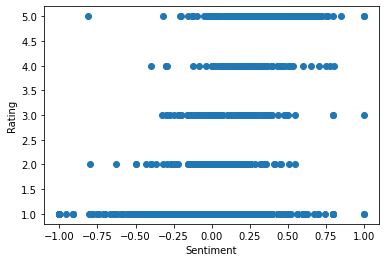

In [16]:
# See chart
import matplotlib.pyplot as plt
from importlib import reload

TOPIC_NAME = "fee"

plt = reload(plt)
x = reviews_df[reviews_df["topic"] == TOPIC_NAME]["sent_pol"] #! When you don't use loc you get a series
y = reviews_df[reviews_df["topic"] == TOPIC_NAME]["rating"]

plt.scatter(x, y)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")


In [17]:
# Create the model and display fit
from sklearn import linear_model
model = linear_model.LinearRegression()
x = reviews_df.loc[reviews_df["topic"] == TOPIC_NAME].loc[:, ["sent_pol"]]
model.fit(x, y)
model.score(x, y)

0.16603032859480216

In [18]:
topic_dict = {
    "app" : "App/UI/Features",
    "fee" : "Fees",
    "transaction" : "Deposit/Withdrawals/Transaction Handling",
    # "R" : "Registration/Verification Process",
    "service" : "Customer Service",
    "trust" : "Trust and Company Reputation",
    "N": "Ignore this"
}

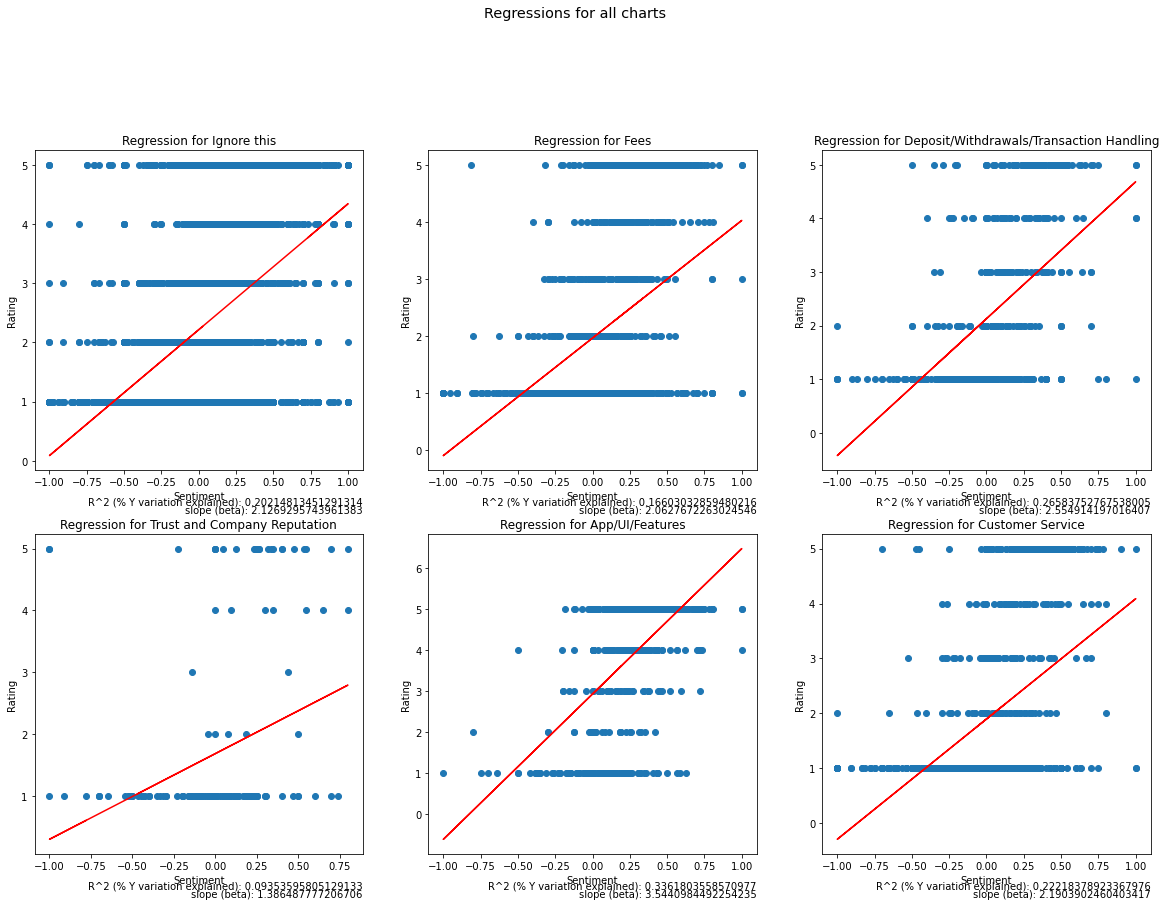

In [19]:
# Now we plot for all the topic
fig = plt.figure(figsize=(20,20))
st = fig.suptitle("Regressions for all charts", fontsize="x-large")

idx = 1
for key in reviews_df["topic"].unique():
    y = reviews_df[reviews_df["topic"] == key]["rating"]
    x = reviews_df.loc[reviews_df["topic"] == key].loc[:, ["sent_pol"]]
    model.fit(x, y)
    score = model.score(x, y)
    x = reviews_df[reviews_df["topic"] == key]["sent_pol"]
    curr_plot = fig.add_subplot(3, 3, idx)
    curr_plot.scatter(x, y)
    curr_plot.set_title(f"Regression for {topic_dict[key]}")
    curr_plot.set_xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
    curr_plot.set_ylabel("Rating")
    curr_plot.plot(x, model.coef_*x + model.intercept_, "r") 
    curr_plot.annotate(f"slope (beta): {model.coef_[0]}",
            xy = (1.0, -0.125),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    curr_plot.annotate(f"R^2 (% Y variation explained): {score}",
            xy = (1.0, -0.1),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

    idx = idx + 1

fig.show()

In [20]:
reviews_df.to_csv("sent_crypto_bow.csv")